In [1]:
from google.colab import drive
drive.mount('/content/drive')

!git clone https://github.com/bbenip/tetris-ai.git

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'tetris-ai' already exists and is not an empty directory.


In [ ]:
%run /content/tetris-ai/data/modify.ipynb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'tetris-ai' already exists and is not an empty directory.

Enter password (will not be echoed): 

Reenter password: 


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/tetris-ai/data/games/games.rar


Would you like to replace the existing file /content/tetris-ai/data/games/8571.json
284713 bytes, modified on 2023-09-08 14:36
with a new one
284713 bytes, modified on 2023-09-08 14:36

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit 
Program aborted
/content/tetris-ai/data/games


Exception ignored in: <function _xla_gc_callback at 0x7b95926df1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x7b95926df1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x7b95926df1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


In [30]:
#import data/data.hdf5
import h5py
import numpy as np
import os
from sklearn.model_selection import train_test_split
DATA_DIR = "/content/tetris-ai/data"
DATASET_FILE_NAME = "data.hdf5"
def load_dataset():
    data_file = os.path.join(DATA_DIR, DATASET_FILE_NAME)
    with h5py.File(data_file, 'r') as hf:
      X_held_blocks = hf.get('X_held_block')[()]
      X_active_blocks = hf.get('X_active_block')[()]
      X_block_positions = hf.get('X_block_pos')[()]
      X_block_rotations = hf.get('X_block_rot')[()]
      X_grids = hf.get('X_grid')[()]
      X_grids = np.reshape(X_grids, (-1, 20, 10))
      Y = hf.get('Y')[()]

      return [X_held_blocks, X_active_blocks, X_block_positions, X_block_rotations, X_grids, Y]

dataset = load_dataset()

'''
grid 20x10x? vector
heldBlock 8 vector 1-hot
activeBlock 7 vector 1-hot
blockPos 2 vector
blockRot 4 vector 1-hot
nextMove 10 vector 1-hot
'''

'\ngrid 20x10x? vector\nheldBlock 8 vector 1-hot\nactiveBlock 7 vector 1-hot\nblockPos 2 vector\nblockRot 4 vector 1-hot\nnextMove 10 vector 1-hot\n'

In [19]:
print(dataset[0].shape)

(53665,)


In [18]:
def scalarToOneHot(n, size):
  vector = np.zeros(size)
  vector[n] = 1
  return vector

In [31]:
dataset[0] = np.array(list(map(lambda x: scalarToOneHot(x, 8), dataset[0])))
dataset[1] = np.array(list(map(lambda x: scalarToOneHot(x, 8), dataset[1])))
dataset[3] = np.array(list(map(lambda x: scalarToOneHot(x, 4), dataset[3])))
dataset[5] = np.array(list(map(lambda x: scalarToOneHot(x, 10), dataset[5])))

print(dataset[0].shape)


(53665, 8)


In [28]:
print(dataset[0])

In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, concatenate
from tensorflow.keras.models import Model

# Define input layers for each type of input
cnn_input = Input((20,10,1))
heldBlock_input = Input((8))
activeBlock_input = Input((8))
rotation_input = Input((4))
position_input = Input((2))

# CNN branch
x = Conv2D(32, (3, 3), activation='relu')(cnn_input)
x = Flatten()(x)

# Branch for 8-vector input
x2 = Dense(16, activation='relu')(heldBlock_input)

# Branch for 7-vector input
x3 = Dense(16, activation='relu')(activeBlock_input)

# Branch for 4-vector input
x4 = Dense(16, activation='relu')(rotation_input)

# Branch for 2-vector input
x5 = Dense(16, activation='relu')(position_input)

# Concatenate all the branches
combined = concatenate([x, x2, x3, x4, x5])

# Add more layers if needed
combined = Dense(64, activation='relu')(combined)
output = Dense(10, activation='softmax')(combined)  # Replace 'output_dim' with the number of output classes or neurons

# Create the model
model = Model(inputs=[cnn_input, heldBlock_input, activeBlock_input, rotation_input, position_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
VALIDATION_SPLIT = 0.2
EPOCHS = 4

In [44]:
# Train the model
history = model.fit(x=[dataset[4], dataset[0], dataset[1], dataset[3], dataset[2]], \
          y=dataset[5], \
          validation_split=VALIDATION_SPLIT, \
          epochs=EPOCHS)

Epoch 1/4
1342/1342 [==============================] - 19s 14ms/step - loss: 1.4841 - accuracy: 0.2993 - val_loss: 1.4698 - val_accuracy: 0.3032
Epoch 2/4
1342/1342 [==============================] - 17s 13ms/step - loss: 1.4688 - accuracy: 0.2984 - val_loss: 1.4527 - val_accuracy: 0.3063
Epoch 3/4
1342/1342 [==============================] - 17s 13ms/step - loss: 1.4557 - accuracy: 0.3007 - val_loss: 1.4604 - val_accuracy: 0.3077
Epoch 4/4
1342/1342 [==============================] - 19s 14ms/step - loss: 1.4482 - accuracy: 0.3043 - val_loss: 1.4507 - val_accuracy: 0.3035


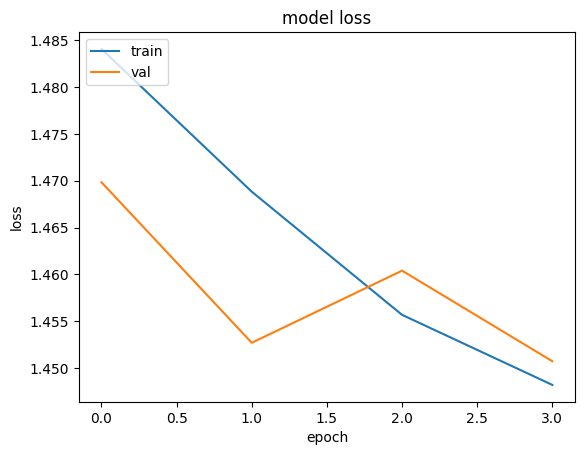

In [45]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()